In [8]:
import numpy as np
import gym as gym
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2 as cv2
import random
# %matplotlib inline
# matplotlib.get_backend()
# plt.isinteractive()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

from utils.epsilon import Epsilon

In [4]:
Transition = namedtuple("Transition", ["s", "a", "s_1", "r", "done"])

a = Transition([0, 1, 2, 3], 0, [4, 5, 6, 7], 0, True)
print(a)

Transition(s=[0, 1, 2, 3], a=0, s_1=[4, 5, 6, 7], r=0, done=True)


In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, item):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = item
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        out = random.sample(self.memory, batch_size)
        batched = Transition(*zip(*out))
        s = np.array(list(batched.s))
        a = np.expand_dims(np.array(list(batched.a)), axis=1)
        s_1 = np.array(list(batched.s_1))
        r = np.expand_dims(np.array(list(batched.r)), axis=1)
        done = np.expand_dims(np.array(list(batched.done)), axis=1)
        return [s, a, s_1, r, done]

    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)
        

memory = ReplayMemory(capacity=4)

for i in range(7):
    memory.push(i)


print("len: ", len(memory))
print("Memory:", memory)

memory = ReplayMemory(capacity=10)

for i in range(10):
    a = Transition([0, 1, 2, 3], 0, [4, 5, 6, 7], 0, True)
    memory.push(a)
    
sample = memory.sample(2)
print(sample)
print(sample[0].shape)
print(sample[1].shape)
print(sample[4])


len:  4
Memory: 4 
5 
6 
3 

[array([[0, 1, 2, 3],
       [0, 1, 2, 3]]), array([[0],
       [0]]), array([[4, 5, 6, 7],
       [4, 5, 6, 7]]), array([[0],
       [0]]), array([[ True],
       [ True]])]
(2, 4)
(2, 1)
[[ True]
 [ True]]


In [72]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = nn.Linear(4, 128)
#         self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(128, 2)
        self.fcv = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        v = self.fcv(x)
        a = self.fc3(x)
        N = a.size()[1]
        q = v + 1/N * a
        
        return q

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([[1, 1, 1, 1], [2, 2, 2, 2]])
# x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
# print(output)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([[0,0], [0, 0]])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear (
  (fc1): Linear (4 -> 128)
  (fc3): Linear (128 -> 2)
  (fcv): Linear (128 -> 1)
)
(2, 4)
(2, 2)


# Ok, now we do DQN with the continuous states received rather than pixels

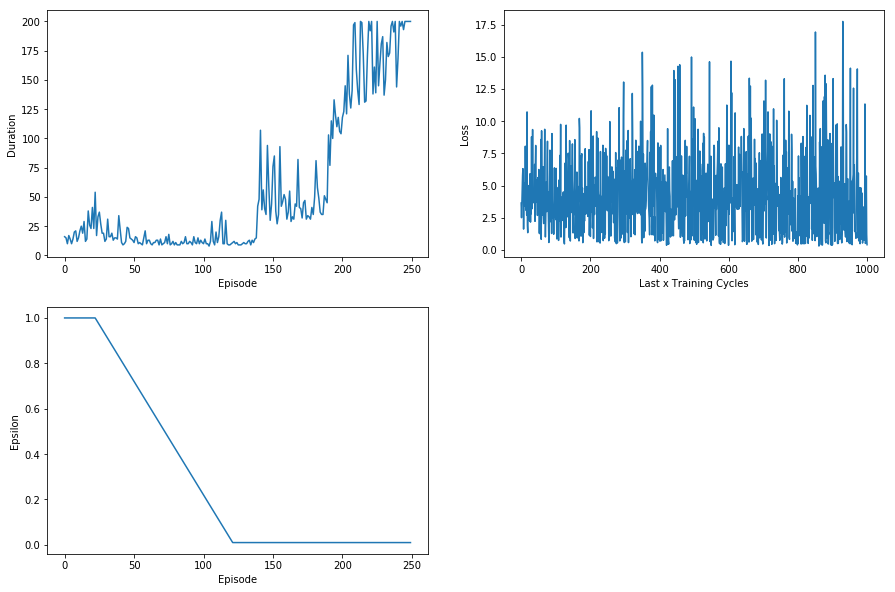

CPU times: user 24.8 s, sys: 26.5 s, total: 51.3 s
Wall time: 13.3 s


In [88]:
import copy
class DQNLinearLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = env
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.01)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 200
        
        self.memory = ReplayMemory(capacity=10000)
        self.Q = DQNLinear()
        self.Qt = copy.deepcopy(self.Q)# DQNLinear()
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.data.numpy())
#             print(actions.data.numpy(), action)
#             print("not exploring", self.epsilon.value())
        else:
            action = self.env.action_space.sample()
#             print("exploring", action, "epsilon:", self.epsilon.value())
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x, volatile=True).float()
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())
            if display is not None and step % 100 == 0:
                display(self)
        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).long()
        s_1 = Variable(torch.from_numpy(s_1), volatile=True).float()
        r = Variable(torch.from_numpy(r)).float()
        done = Variable(torch.from_numpy(1 - done)).float()
        
        # Q_sa = r + gamma * max(Q_s'a')
        Q = self.Q(s)
#         print("s:", s, "Q:", Q)
        Q = Q.gather(1, a)
#         print("a:", a, "Q:", Q)
        Qt = self.Qt(s_1)
#         print("s_1:", s_1, "Qt:", Qt)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        y.volatile = False #weird

        loss = self.criterion(Q, y)
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.Qt = copy.deepcopy(self.Q)

    def run(self):
        self.reset()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
    
env = gym.make("CartPole-v0")
learner = DQNLinearLearner(env, double_Q=True)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

%time learner.train(250, show_chart)
# learner.train(1)


In [89]:
###### learner.train(100, show_chart)
for i in range(3):
    learner.run()
# display.clear_output(wait=True)

Total Reward:  200.0
Total Reward:  187.0
Total Reward:  194.0


# Lessons Learnt
- changing target_q_update_frequency from 100 to 200 helps
- a learning rate decay starting from 1e-2 to 1e-3 would probably help